# Image Understanding Final Project Source Code
## Group A:
* Javier Miguel González
* Carlos Moro Jiménez
* Paula Calvo Gallego
* Belén Ferrón Hurtado
* Antonio Ramírez Soláns
* Ignacio López Carboneras

## Step 1: Load dataset from tensorflow


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


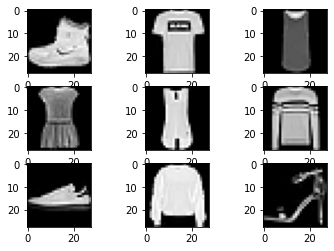

In [1]:
# example of loading the fashion mnist dataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import precision_recall_fscore_support as score

# load dataset
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

## Step 2: Preprocessing the data

### Centering and Normalization
        Perform centering by mean subtraction, and normalization by dividing with 
        the standard deviation of the training dataset.

In [2]:
trainX = trainX / 255.0
testX = testX / 255.0
train_data_mean = np.mean(trainX)
train_data_stdev = np.std(trainX)
train_data = ((trainX - train_data_mean) / train_data_stdev, trainY)
test_data = ((testX - train_data_mean) / train_data_stdev, testY)

## Step 3: Feature Extraction
We are going to use the autoencoder cnn used in the individual deliverable 2.

In [3]:
def autoencoder_model(input_shape=(28, 28, 1)):
    """ Autoencoder model """
    input_img = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dense(8, activation='sigmoid')(x)
    
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    x = Dense(8, activation='sigmoid')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

autoencoder = autoencoder_model()
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
dense (Dense)                (None, 7, 7, 8)           72        
_________________________________________________________________
encoder (MaxPooling2D)       (None, 4, 4, 8)           0     

In [4]:
tf.random.set_seed(5)

model_name = 'cnn_mnist.h5'

if not os.path.exists(model_name):
    autoencoder = autoencoder_model()
    autoencoder.fit(trainX, trainX,
                    epochs=12,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(testX, testX))

    autoencoder.save(model_name)
else:
    autoencoder = load_model(model_name)

In [5]:
# Obtain features from middle layer
autoencoder = load_model(model_name)
encoder = Model(inputs=autoencoder.input, 
                outputs=autoencoder.get_layer('encoder').output)

In [6]:
# Extracting features from train data
codes_name = 'learned_codes_mnist_our_cnn.npy'

if not os.path.exists(codes_name):
    learned_codes = encoder.predict(trainX)
    # The sise of the latent space is (None, 4, 4, 8), 
    # so we have to vectorize it.
    learned_codes = learned_codes.reshape(learned_codes.shape[0],
                                          learned_codes.shape[1] * 
                                          learned_codes.shape[2] * 
                                          learned_codes.shape[3])
    np.save(codes_name, learned_codes)
else:
    learned_codes = np.load(codes_name)

In [7]:
def euclidean_distance(x ,y):
    return np.sqrt(np.sum(np.square(x - y)))
def cosine_similarity_distance(x, y):
     # Normalize vectors
    norm_x = x / np.linalg.norm(x)
    norm_y = y / np.linalg.norm(y)
    # Calculate distance
    return np.dot(norm_x, norm_y) / (np.sqrt(np.dot(norm_x, norm_x)) * np.sqrt(np.dot(norm_y, norm_y)))

In [8]:
DISTANCE_ALG = 'cosine'
num_retrieve_images = 9
np.random.seed(5)
    
indexes = np.random.randint(0, testX.shape[0], 500) # Select 8 random images for testing
predicted = []
y_test = []
for idx in indexes:
    # Extract features from test image
    im_test = testX[idx]
    test_code = encoder.predict(np.expand_dims(im_test, axis=0))
    test_code = test_code.reshape(test_code.shape[0], test_code.shape[1] * 
                                    test_code.shape[2] * test_code.shape[3])
    test_code = np.squeeze(test_code)
    
    # Calculate the distance from
    distances = []
    for code in learned_codes:
        if(DISTANCE_ALG == 'euclidean'):
            distance = euclidean_distance(code, test_code) # Euclidean norm
        elif(DISTANCE_ALG == 'cosine'):
            distance = cosine_similarity_distance(code, test_code)
        distances.append(distance)
    distances = np.array(distances)

    
    # Ordering the images according to similarity
    sorted_idx = distances.argsort()
    if(DISTANCE_ALG == 'cosine'):
        sorted_idx = np.flip(sorted_idx)

    # Print test image and most similar image
    
    image = im_test
    for i in range(2):
        '''
        # define subplot
        plt.subplot(330 + 1 + i)
        # plot raw pixel data
        plt.imshow(image, cmap=plt.get_cmap('gray'))
        image = trainX[sorted_idx[0]] 
    # show the figure
    plt.show()
    '''
    classTest = trainY[sorted_idx[0]]
    predicted.append(classTest)
    y_test.append(testY[idx])

y_test = np.array(y_test)
predicted = np.array(predicted)

precision, recall, fscore, support = score(y_test, predicted)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print('Average Precision: {}'.format(np.sum(precision)/10))
print('Average F-Score: {}'.format(np.sum(fscore)/10))
print('Average Recall: {}'.format(np.sum(recall)/10))
    

precision: [0.81818182 0.96610169 0.71794872 0.87234043 0.7755102  0.9787234
 0.49090909 0.89795918 0.98214286 0.90909091]
recall: [0.72       0.98275862 0.7        0.80392157 0.80851064 0.93877551
 0.57446809 0.89795918 0.98214286 0.94339623]
fscore: [0.76595745 0.97435897 0.70886076 0.83673469 0.79166667 0.95833333
 0.52941176 0.89795918 0.98214286 0.92592593]
support: [50 58 40 51 47 49 47 49 56 53]
Average Precision: 0.8408908305730984
Average F-Score: 0.8371351605986842
Average Recall: 0.8351932690156862
